## Parabolic mirror transform

P. Huft

Note: all length units in mm. 

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from matplotlib import colors
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

In [3]:
z_fresnel = lambda dx,dy,k: (k*(dx**2+dy**2)**2/(8*pi))**(1/3)
z_fresnel(9,9,2*pi/(8.5e-4))/1e3

0.19762886237040608

## testing

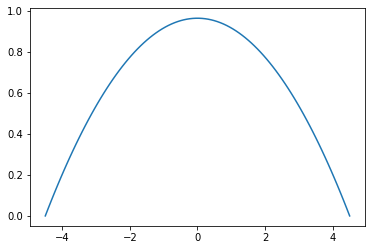

In [112]:
## define the surface. OpticStudio nomenclature.

r = 10.5 # best fit sphere radius of curvature
semi_dia = 4.5 # mechanical radius

# zpts = linspace(r*(1-0.5*(semi_dia/r)**2),r,100)
# sag_inverse = lambda z: sqrt(2*r**2*(1-z/r))
# plt.plot(zpts,sag_inverse(zpts))
# plt.plot(zpts,-sag_inverse(zpts))

rho_pts = linspace(-semi_dia,semi_dia,100)
sag = lambda rho: r*(1-0.5*(rho/r)**2)
min_sag = min(sag(rho_pts))
sag = lambda rho: r*(1-0.5*(rho/r)**2) - min_sag
plt.plot(rho_pts, sag(rho_pts))

rr.shape = (6001, 6001)


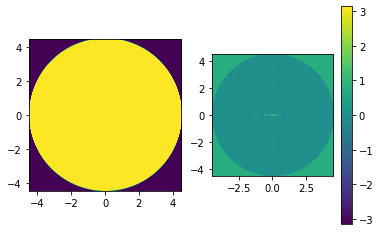

In [113]:
## create a phase mask.

## physics and system params
lmbda = 8.52e-4
k = 2*pi/lmbda

NA_to_waist = lambda NA: lmbda/(pi*tan(arcsin(NA)))

## grid params
w = 4.5 # grid half-width
pts = 6001
x0pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)
print('rr.shape =', rr.shape)

aper = circ_mask(rr, semi_dia).astype(complex)

phase = k*sag(rr)

# plt.imshow(phase)

mask = aper*exp(-1j*phase)

fig, axes = plt.subplots(nrows=1,ncols=2)
ax1,ax2 = axes
ax1.set_aspect(1)
ax2.set_aspect(1)
ax1.imshow(abs(mask), extent=[-w,w,-w,w])
cax = ax2.imshow(angle(mask), extent=[-w,w,-w,w])

# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)

C:\Users\prest\AppData\Local\Temp/ipykernel_22516/2073703665.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow(phase*aper.astype(float))


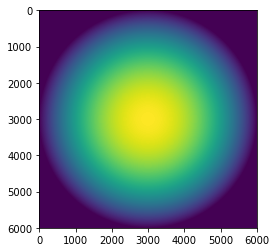

In [115]:
plt.imshow(phase*aper.astype(float))

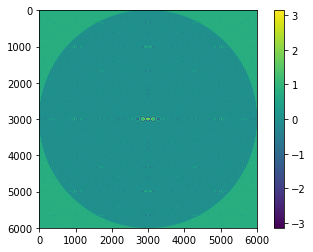

In [114]:
fig,ax = plt.subplots()
cax = ax.imshow(angle(mask))#, extent=[-w,w,-w,w])

# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)

In [19]:
help(angle)

Help on function angle in module numpy:

angle(z, deg=False)
    Return the angle of the complex argument.
    
    Parameters
    ----------
    z : array_like
        A complex number or sequence of complex numbers.
    deg : bool, optional
        Return angle in degrees if True, radians if False (default).
    
    Returns
    -------
    angle : ndarray or scalar
        The counterclockwise angle from the positive real axis on the complex
        plane in the range ``(-pi, pi]``, with dtype as numpy.float64.
    
        .. versionchanged:: 1.16.0
            This function works on subclasses of ndarray like `ma.array`.
    
    See Also
    --------
    arctan2
    absolute
    
    Notes
    -----
    Although the angle of the complex number 0 is undefined, ``numpy.angle(0)``
    returns the value 0.
    
    Examples
    --------
    >>> np.angle([1.0, 1.0j, 1+1j])               # in radians
    array([ 0.        ,  1.57079633,  0.78539816]) # may vary
    >>> np.angle(1+1j, d

(2.0, 3.0)

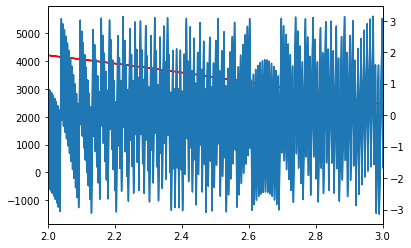

In [103]:
## zoom in to see how the phase varies with rho. 
fig,ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(rr[pts//2,:],phase[pts//2,:],color='red')
ax2.plot(rr[pts//2,:],angle(exp(1j*phase[pts//2,:])))
ax.set_xlim((2,3))

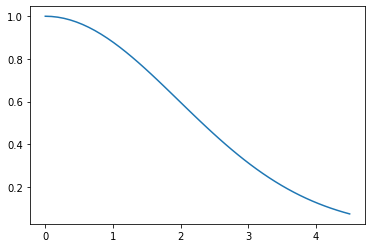

In [117]:
## define a Gaussian beam

# waist after transforming SM fiber mode by lens f

f = 30
wf = NA_to_waist(0.13)
w0 = lmbda*f/(pi*wf)

gaussian = lambda rho: exp(-2*rho**2/w0**2)

rho_pts = linspace(0,4.5)
plt.plot(rho_pts,gaussian(rho_pts))

In [124]:
## propagate beam to focal plane of parabolic mirror

# field before mirror.
# neglect finite radius of curvature (collimated beam)

field0 = gaussian(rr)

# field after mirror transform
field1 = field0*mask

# field after propagating -z from mirror
z = -5.25
padding = pts//2
field2,x2pts = propagate(z,field1,k,x0pts,rr,padding)

z = -5.25
calculated field2 in 39.418046712875366 s


In [122]:
res = 1/(x0pts[1]-x0pts[0])*(2*pi/k)*z/(2*padding + pts)
res

0.00024847929339220784

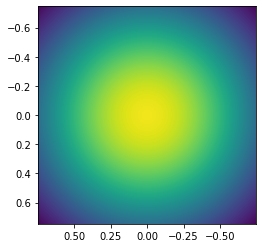

In [125]:
w = x2pts[-1]
fig,ax = figax()
I2 = abs(field2)**2
I2 /= amax(I2)
cax = ax.imshow(I2, extent=[-w,w,-w,w])
# ax.set_xlim((-0.05,0.05))
# ax.set_ylim((-0.05,0.05))